When the experimental spectrum is noisy, a manual peak selection is required.
This examples show how this can be done.

In [2]:
import os

import matplotlib.pyplot as py
import numpy as np

from irsa.core.utils import load_spectrum, normalize_spectrum, load_peaks
from irsa.core.spectrum_functions import deconvolute, voigt
from irsa.core.algorithm import Algorithm
from irsa.core.analyses import get_spearman_and_pearson


Load experimental Spectrum and visualize

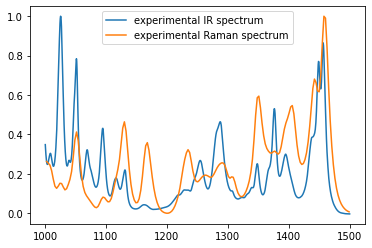

In [3]:
path_to_experimental_dir = f"{os.path.abspath('')}/data/experimental_spectra/"
experimental_ir_spectrum = normalize_spectrum(load_spectrum(f"{path_to_experimental_dir}/ir_cdcl3.txt"), lower=1000, upper=1500)
experimental_raman_spectrum = normalize_spectrum(load_spectrum(f"{path_to_experimental_dir}/raman_cdcl3.txt"), lower=1000, upper=1500)


py.plot(experimental_ir_spectrum[:, 0], experimental_ir_spectrum[:, 1], label="experimental IR spectrum")
py.plot(experimental_raman_spectrum[:, 0], experimental_raman_spectrum[:, 1], label="experimental Raman spectrum")
py.legend()

Load spectrum from isomer_0

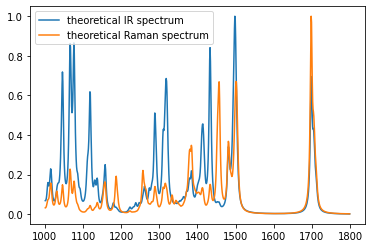

In [4]:
path_to_theoretical_dir = f"{os.path.abspath('')}/data/theoretical_spectra/"

theoretical_ir_spectrum = normalize_spectrum(load_spectrum(f"{path_to_theoretical_dir}/isomer_0/ir_spectrum"), lower=1000, upper=1800)
theoretical_raman_spectrum = normalize_spectrum(load_spectrum(f"{path_to_theoretical_dir}/isomer_0/raman_spectrum"), lower=1000, upper=1800)

py.plot(theoretical_ir_spectrum[:, 0], theoretical_ir_spectrum[:, 1], label="theoretical IR spectrum")
py.plot(theoretical_raman_spectrum[:, 0], theoretical_raman_spectrum[:, 1], label="theoretical Raman spectrum")
py.legend()

Load manual selected Peaks

In [5]:
manual_selected_ir_peaks = np.loadtxt(f"{os.path.abspath('')}/ir_exp_manual_selected.txt", usecols=(0,), dtype=np.float64)
manual_selected_raman_peaks = np.loadtxt(f"{os.path.abspath('')}/raman_exp_manual_selected.txt", usecols=(0,), dtype=np.float64)

Perform deconvolution of experimental and theoretical spectra, save it to file

In [6]:
deconvolute(spectrum=theoretical_ir_spectrum, working_dir=os.path.abspath(''), save_data='ir_theo_peaks.txt', normalize=True, lower=1000, higher=1800, vcd=False)
deconvolute(spectrum=theoretical_raman_spectrum, working_dir=os.path.abspath(''), save_data='raman_theo_peaks.txt', normalize=True, lower=1000, higher=1800, vcd=False)
deconvolute(peaks_on_x_axis=manual_selected_ir_peaks, spectrum=experimental_ir_spectrum, working_dir=os.path.abspath(''), save_data='ir_exp_peaks.txt', normalize=True, lower=1000, higher=1500, vcd=False)
deconvolute(peaks_on_x_axis=manual_selected_raman_peaks, spectrum=experimental_raman_spectrum, working_dir=os.path.abspath(''), save_data='raman_exp_peaks.txt', normalize=True, lower=1000, higher=1500, vcd=False)

TypeError: deconvolute() got an unexpected keyword argument 'peaks_on_x_axis'

Load peaks and concatenate them accordingly

Notice the use of kind of spectra. The numbers are arbitrary, however, 2 is reserved for VCD, since it allows for negative intensities.
If you want to apply the algorithm for any other spectroscopy methods, you can just replace the numbers. Also, if you have more types, u can also accound for this, by just appending another integer.
Notice that you would have to adapt the scoring function in irsa.core.algorithm

In [5]:
exp_peaks = load_peaks(paths=[f"{os.path.abspath('')}/ir_exp_peaks.txt", f"{os.path.abspath('')}/raman_exp_peaks.txt"], kind_of_spectra=[0, 1]) # first IR (0), second Raman (1), vcd would be (2)
theo_peaks = load_peaks(paths=[f"{os.path.abspath('')}/ir_theo_peaks.txt", f"{os.path.abspath('')}/raman_theo_peaks.txt"], kind_of_spectra=[0, 1])

Initialize Algorithm, perform Alignment

In [6]:

algo = Algorithm(exp_peaks=exp_peaks, theo_peaks=theo_peaks, lower_bound=1000, upper_bound=1500, sc=0.975, cutoff=0.01)
return_value, old_freq, freq, inten, new_sigma, new_eta, kind_of_spectrum = algo.needleman()


Freq, inten, new_sigma, and eta_new contain all the information to create the aligned theoretical spectra. This is going to be the next step.

In [7]:
x_ir, y_ir = voigt(freqs=freq[kind_of_spectrum==0], inten=inten[kind_of_spectrum==0], new_sigma=new_sigma[kind_of_spectrum==0], new_eta=new_eta[kind_of_spectrum==0]) # get convoluted ir Spectrum
x_raman, y_raman = voigt(freqs=freq[kind_of_spectrum==1], inten=inten[kind_of_spectrum==1], new_sigma=new_sigma[kind_of_spectrum==1], new_eta=new_eta[kind_of_spectrum==1]) # get convoluted raman Spectrum

Overlay spectra

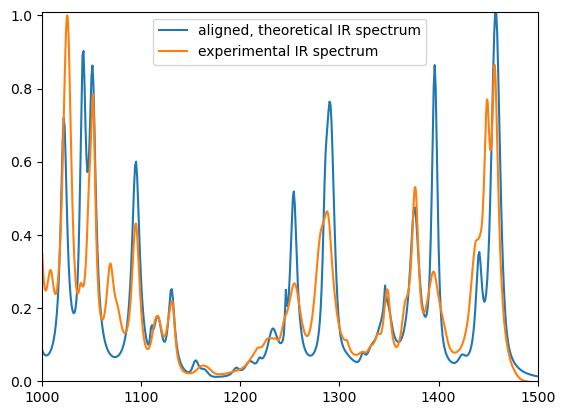

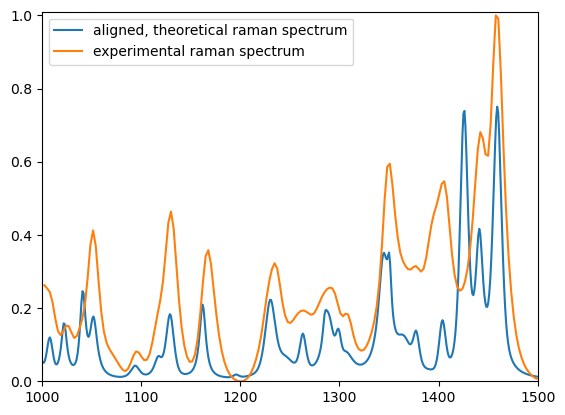

In [8]:
py.plot(x_ir, y_ir, label="aligned, theoretical IR spectrum")
py.plot(experimental_ir_spectrum[:, 0], experimental_ir_spectrum[:, 1], label="experimental IR spectrum")
py.legend()
py.xlim(1000, 1500)
py.ylim(0, 1.01)
py.show()
py.plot(x_raman, y_raman, label="aligned, theoretical raman spectrum")
py.plot(experimental_raman_spectrum[:, 0], experimental_raman_spectrum[:, 1], label="experimental raman spectrum")
py.legend()
py.xlim(1000, 1500)
py.ylim(0, 1.01)

py.show()


Compute spearman and pearson overlaps for spectra

In [9]:
pearson_ir, spearman_ir = get_spearman_and_pearson(spectrum_exp=experimental_ir_spectrum, spectrum_theo=np.concatenate([x_ir[:, np.newaxis], y_ir[:, np.newaxis]], axis=-1))
pearson_raman, spearman_raman = get_spearman_and_pearson(spectrum_exp=experimental_raman_spectrum, spectrum_theo=np.concatenate([x_raman[:, np.newaxis], y_raman[:, np.newaxis]], axis=-1))
print(pearson_ir, spearman_ir)
print(pearson_raman, spearman_raman)

0.7573291532579767 0.8888286190478257
0.710320724783553 0.7916627242305739
